## Restricted Boltzmann Machine on MNIST

### RBM

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# -------------------------------
# 1️⃣ Set device (CPU or MPS)
# -------------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [10]:

# -------------------------------
# 2️⃣ RBM Class
# -------------------------------
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        # Trainable parameters
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))

    # Sample hidden units given visible
    def sample_h(self, v):
        prob_h = torch.sigmoid(F.linear(v, self.W.t(), self.h_bias))
        h_sample = torch.bernoulli(prob_h)
        return prob_h, h_sample

    # Sample visible units given hidden
    def sample_v(self, h):
        prob_v = torch.sigmoid(F.linear(h, self.W, self.v_bias))
        v_sample = torch.bernoulli(prob_v)
        return prob_v, v_sample

    # One step of CD-1
    def contrastive_divergence(self, v0, k=1):
        # Positive phase
        ph0, h0 = self.sample_h(v0)

        #start chain at data
        vk = v0
        for step in range(k):
            _, hk = self.sample_h(vk)
            _, vk = self.sample_v(hk)

        # Negative phase (reconstruction)
        phk, _ = self.sample_h(vk)

        # Weight and bias update (batch normalized)
        batch_size = v0.size(0)
        self.W.data += self.lr * (v0.t() @ ph0 - vk.t() @ phk) / batch_size
        self.v_bias.data += self.lr * torch.mean(v0 - vk, dim=0)
        self.h_bias.data += self.lr * torch.mean(ph0 - phk, dim=0)

        # Reconstruction error
        return torch.mean((v0 - vk) ** 2)

    # Forward method (return hidden probabilities)
    def forward(self, v):
        prob_h, _ = self.sample_h(v)
        return prob_h


### Load Dataset

In [11]:
# -------------------------------
# 3️⃣ Load MNIST
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### binarizing data

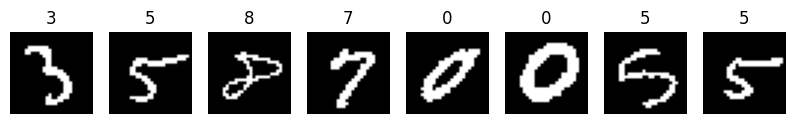

In [24]:

# Get one batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot first 8 images
plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'{int(labels[i])}')
    plt.axis('off')
plt.show()

In [26]:
# Get one batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Take the first image
v = images[0].view(-1)  # flatten to 784-d vector
label = labels[0]

print("Label:", label.item())
print("v (flattened visible units):\n", v)

Label: 6
v (flattened visible units):
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
 

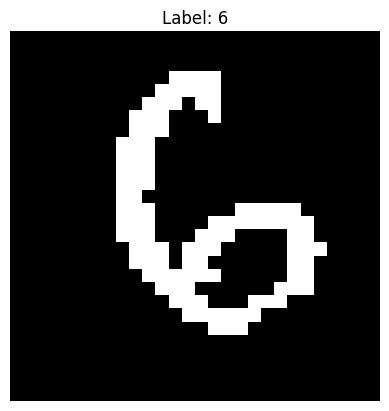

In [27]:
import matplotlib.pyplot as plt

# Take the first image from the batch
v = images[0].view(-1)  # flattened
v_image = v.view(28, 28)  # reshape back to 28x28

# Plot the image
plt.imshow(v_image, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()

### Train RBM

In [12]:
# -------------------------------
# 4️⃣ Initialize RBM
# -------------------------------
rbm = RBM(n_visible=784, n_hidden=256, learning_rate=0.01).to(device)

# -------------------------------
# 5️⃣ Training Loop
# -------------------------------
epochs = 30
k = 5  # CD-5

for epoch in range(epochs):
    epoch_error = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784).to(device)
        err = rbm.contrastive_divergence(batch, k=k)
        epoch_error += err.item()

    avg_error = epoch_error / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Reconstruction Error: {avg_error:.4f}")

Epoch 1/30, Reconstruction Error: 0.1700
Epoch 2/30, Reconstruction Error: 0.1250
Epoch 3/30, Reconstruction Error: 0.1135
Epoch 4/30, Reconstruction Error: 0.1065
Epoch 5/30, Reconstruction Error: 0.1014
Epoch 6/30, Reconstruction Error: 0.0976
Epoch 7/30, Reconstruction Error: 0.0945
Epoch 8/30, Reconstruction Error: 0.0919
Epoch 9/30, Reconstruction Error: 0.0896
Epoch 10/30, Reconstruction Error: 0.0877
Epoch 11/30, Reconstruction Error: 0.0860
Epoch 12/30, Reconstruction Error: 0.0844
Epoch 13/30, Reconstruction Error: 0.0830
Epoch 14/30, Reconstruction Error: 0.0818
Epoch 15/30, Reconstruction Error: 0.0806
Epoch 16/30, Reconstruction Error: 0.0796
Epoch 17/30, Reconstruction Error: 0.0786
Epoch 18/30, Reconstruction Error: 0.0776
Epoch 19/30, Reconstruction Error: 0.0767
Epoch 20/30, Reconstruction Error: 0.0760
Epoch 21/30, Reconstruction Error: 0.0752
Epoch 22/30, Reconstruction Error: 0.0746
Epoch 23/30, Reconstruction Error: 0.0738
Epoch 24/30, Reconstruction Error: 0.0732
E

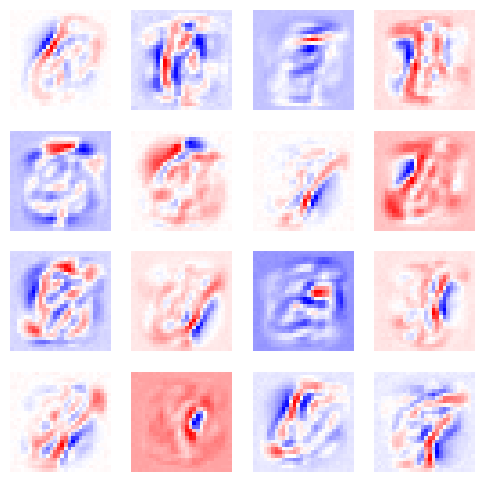

In [122]:
# -------------------------------
# 6️⃣ Visualize learned hidden weights
# -------------------------------
W = rbm.W.cpu().detach().numpy()
plt.figure(figsize=(6,6))
for i in range(16):  # first 16 hidden units
    plt.subplot(4,4,i+1)
    plt.imshow(W[:,i].reshape(28,28), cmap='bwr')
    plt.axis('off')
plt.show()

###  using t-SNE to plot them in 2D

In [20]:

def get_rbm_features(loader, rbm):
    features, labels = [], []
    rbm.eval()
    with torch.no_grad():
        for batch, target in loader:
            batch = batch.view(-1, rbm.n_visible).to(next(rbm.parameters()).device)
            
            # Get hidden probabilities
            prob_h, _ = rbm.sample_h(batch)
            
            # Clamp and validate
            prob_h = torch.clamp(prob_h, 0.0, 1.0)
            
            # Check for bad values
            if torch.isnan(prob_h).any() or torch.isinf(prob_h).any():
                print("⚠️ Warning: NaN/Inf detected in RBM features!")
                prob_h = torch.nan_to_num(prob_h, nan=0.0, posinf=1.0, neginf=0.0)
            
            features.append(prob_h.cpu())
            labels.append(target)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    # Debug info
    print(f"✓ Features shape: {features.shape}")
    print(f"✓ Range: [{features.min():.3f}, {features.max():.3f}]")
    print(f"✓ Mean: {features.mean():.3f}, Std: {features.std():.3f}")
    
    return features, labels

train_features, train_labels = get_rbm_features(train_loader, rbm)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features.numpy())

# Check scaled features
print(f"✓ Scaled range: [{train_features_scaled.min():.3f}, {train_features_scaled.max():.3f}]")

✓ Features shape: torch.Size([60000, 256])
✓ Range: [0.000, 1.000]
✓ Mean: 0.402, Std: 0.427
✓ Scaled range: [-3.057, 4.490]


✓ Features shape: torch.Size([60000, 64])
✓ Range: [0.000, 1.000]
✓ Mean: 0.498, Std: 0.475
✓ Scaled range: [-2.065, 2.485]


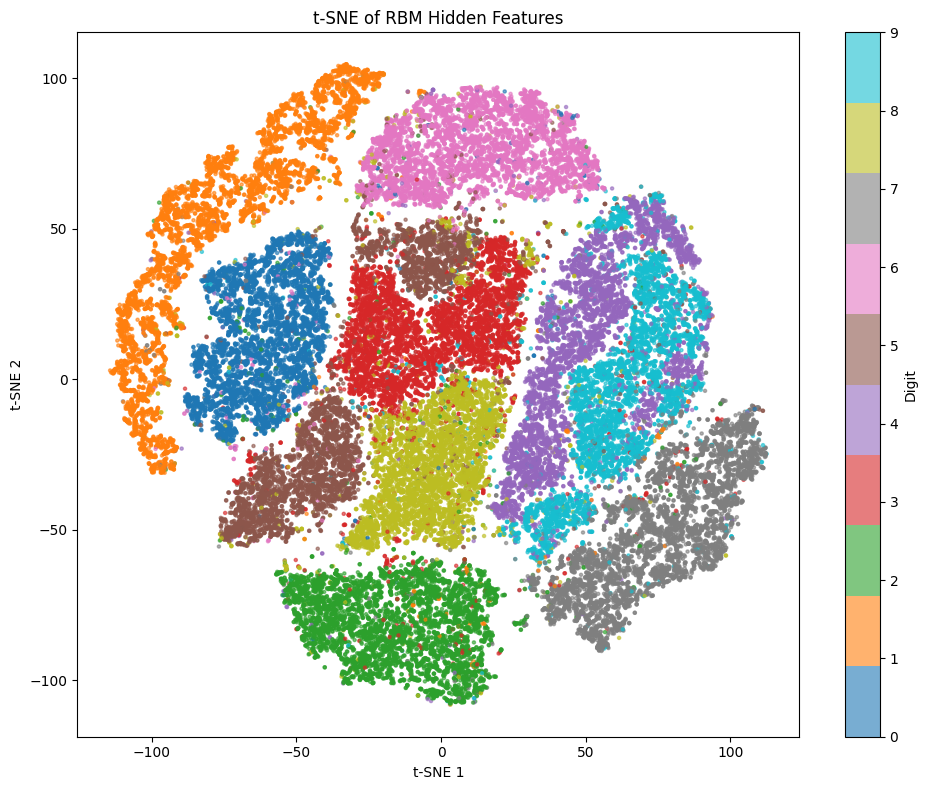

In [ ]:


# t-SNE with safer settings
tsne = TSNE(
    n_components=2,
    random_state=42,
    init='random',  # Avoid PCA numerical issues
    learning_rate='auto',
    perplexity=30,
    max_iter=1000
)

features_2d = tsne.fit_transform(train_features_scaled)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    features_2d[:, 0], 
    features_2d[:, 1], 
    c=train_labels, 
    cmap='tab10', 
    s=5, 
    alpha=0.6
)
plt.colorbar(scatter, label='Digit')
plt.title("t-SNE of RBM Hidden Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

### Using k-NN classifier to group them

In [17]:
# -------------------------------
# 1️⃣ MNIST dataset and loaders
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize images
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:


# -------------------------------
# 1️⃣ Extract RBM hidden features for train and test sets
# ------------------------------

train_features, train_labels = get_rbm_features(train_loader, rbm)
test_features, test_labels   = get_rbm_features(test_loader, rbm)

# -------------------------------
# 2️⃣ Train a simple k-NN classifier
# -------------------------------
knn = KNeighborsClassifier(n_neighbors=3)  # k=3 works well for MNIST features
knn.fit(train_features, train_labels)

# -------------------------------
# 3️⃣ Evaluate on test set
# -------------------------------
test_preds = knn.predict(test_features)
accuracy = accuracy_score(test_labels, test_preds)

print(f"Classification accuracy using RBM hidden features: {accuracy*100:.2f}%")

✓ Features shape: torch.Size([60000, 256])
✓ Range: [0.000, 1.000]
✓ Mean: 0.402, Std: 0.427
✓ Features shape: torch.Size([10000, 256])
✓ Range: [0.000, 1.000]
✓ Mean: 0.400, Std: 0.427
Classification accuracy using RBM hidden features: 97.12%


### Using MLP to classify the representations

In [23]:

# -------------------------------
# 1️⃣ Load and binarize MNIST
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize pixels
])

train_loader = DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST(root="./data", train=False, download=True, transform=transform),
    batch_size=64, shuffle=False
)


# -------------------------------
# 2️⃣ Prepare DataLoaders 
# -------------------------------
train_loader_nn = DataLoader(
    TensorDataset(train_features, train_labels),
    batch_size=64, shuffle=True
)
test_loader_nn = DataLoader(
    TensorDataset(test_features, test_labels),
    batch_size=64, shuffle=False
)

# -------------------------------
# 3️⃣ Define MLP
# -------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

mlp = MLP(input_dim=rbm.n_hidden).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# -------------------------------
# 4️⃣ Train MLP
# -------------------------------
for epoch in range(10):
    mlp.train()
    total_loss = 0
    for x, y in train_loader_nn:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(mlp(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10 | Loss: {total_loss/len(train_loader_nn):.4f}")

# -------------------------------
# 5️⃣ Evaluate
# -------------------------------
mlp.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader_nn:
        x, y = x.to(device), y.to(device)
        preds = mlp(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Test Accuracy (RBM features → MLP): {100*correct/total:.2f}%")

Epoch 1/10 | Loss: 0.3450
Epoch 2/10 | Loss: 0.1782
Epoch 3/10 | Loss: 0.1362
Epoch 4/10 | Loss: 0.1104
Epoch 5/10 | Loss: 0.0941
Epoch 6/10 | Loss: 0.0813
Epoch 7/10 | Loss: 0.0728
Epoch 8/10 | Loss: 0.0646
Epoch 9/10 | Loss: 0.0575
Epoch 10/10 | Loss: 0.0520
Test Accuracy (RBM features → MLP): 97.52%


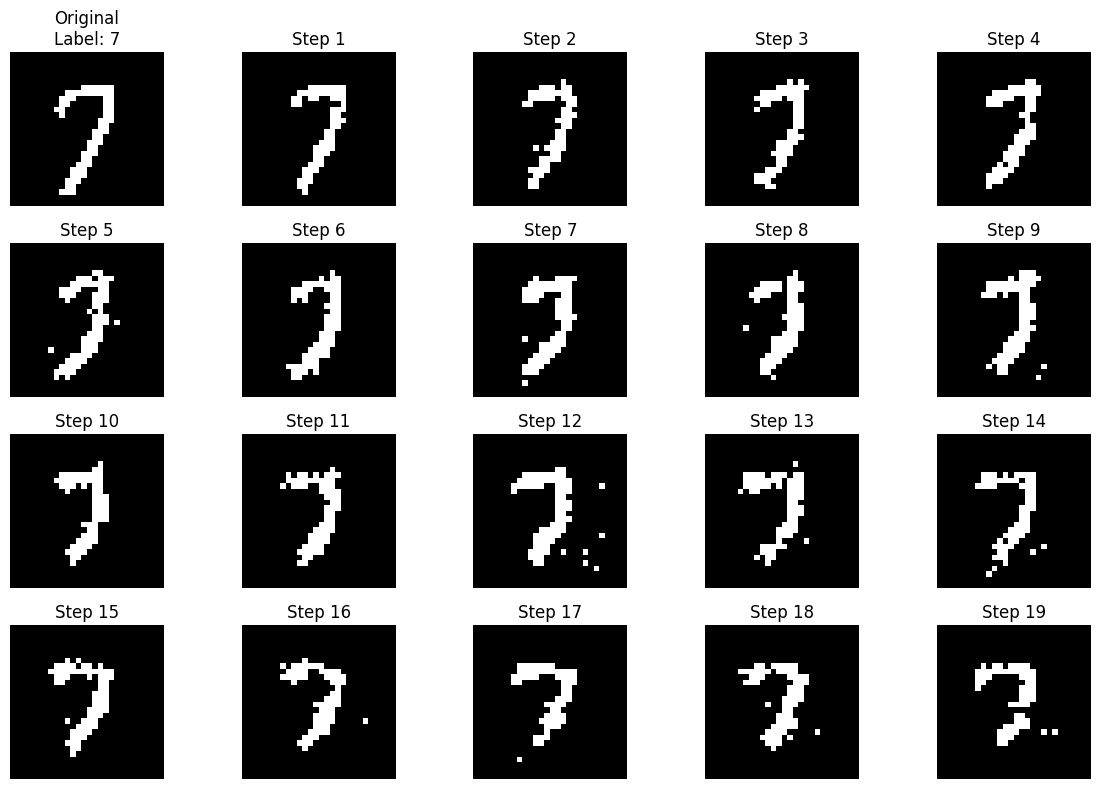

In [55]:
import torch
import matplotlib.pyplot as plt

device = next(rbm.parameters()).device  # RBM device

# Take one binarized image from loader
v0, label = next(iter(train_loader))
v0 = v0[0].view(1, -1).to(device)
label = label[0].item()

# Gibbs chain
k = 20
vk = v0.clone()
images = [vk]  # store on device

for step in range(k):
    _, hk = rbm.sample_h(vk)
    _, vk = rbm.sample_v(hk)
    images.append(vk)

# Plot in 4 rows x 5 columns (show first 20 images)
plt.figure(figsize=(12,8))
for i, img in enumerate(images[:20]):  # first 20 images
    img_cpu = img.view(28,28).detach().cpu()
    plt.subplot(4, 5, i+1)
    plt.imshow(img_cpu, cmap='gray')
    if i == 0:
        plt.title(f"Original\nLabel: {label}")
    else:
        plt.title(f"Step {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

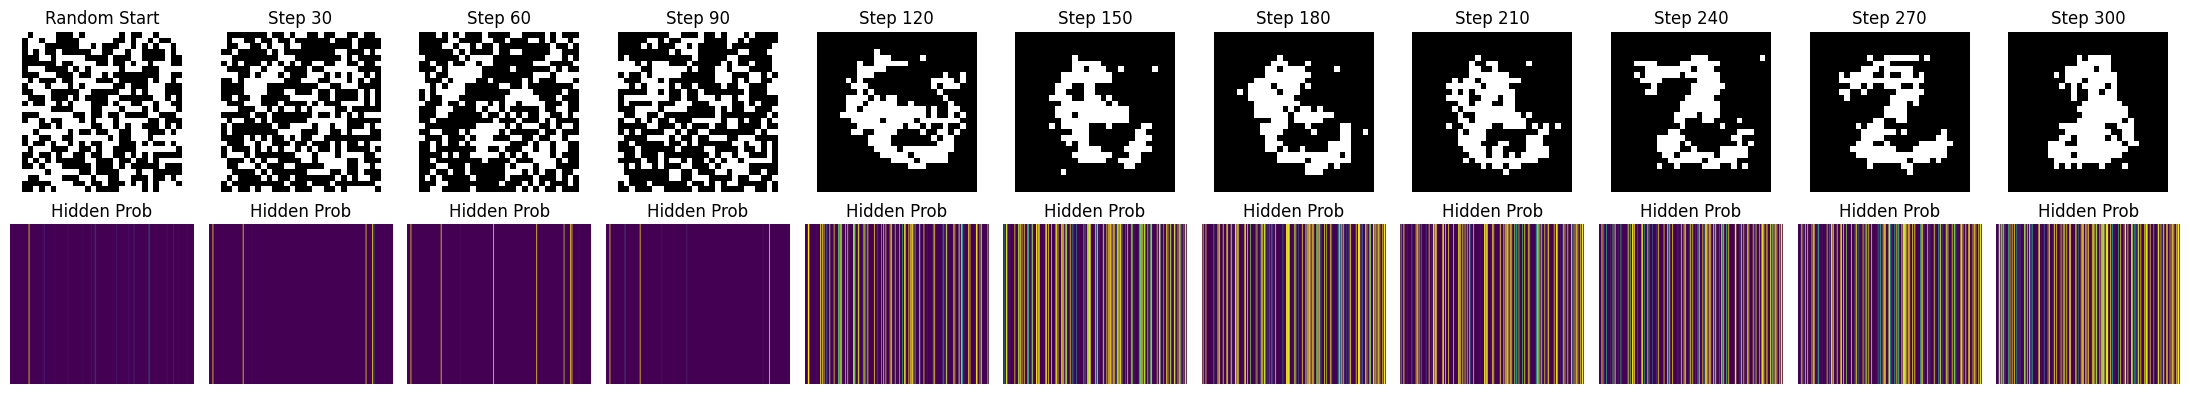

In [118]:
import torch
import matplotlib.pyplot as plt

device = next(rbm.parameters()).device  # RBM device

# Start from a random binary image
vk = torch.bernoulli(torch.rand(1, 784)).to(device)
prob_h, _ = rbm.sample_h(vk)
images_v = [vk.clone()]
images_h_prob = [prob_h.clone()]  # store probabilities, not samples

total_steps = 300
plot_every = 30

# Gibbs sampling
for step in range(1, total_steps+1):
    prob_h, hk = rbm.sample_h(vk)
    _, vk = rbm.sample_v(hk)
    
    if step % plot_every == 0:
        images_v.append(vk.clone())
        images_h_prob.append(prob_h.clone())  # store hidden probabilities

# Number of snapshots
n_snapshots = len(images_v)

# Plot visible (top row) and hidden probabilities (bottom row)
plt.figure(figsize=(22, 4))
for i in range(n_snapshots):
    # Visible units
    plt.subplot(2, n_snapshots, i+1)
    plt.imshow(images_v[i].view(28,28).detach().cpu(), cmap='gray')
    if i == 0:
        plt.title("Random Start")
    else:
        plt.title(f"Step {i*plot_every}")
    plt.axis('off')
    
    # Hidden probabilities
    plt.subplot(2, n_snapshots, n_snapshots + i + 1)
    plt.imshow(images_h_prob[i].view(1, -1).detach().cpu(), cmap='viridis', aspect='auto')
    plt.title("Hidden Prob")
    plt.axis('off')

plt.tight_layout()
plt.show()